In [1]:
%matplotlib inline


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. 
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents.
It will be automatically downloaded, then cached. 

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.




In [18]:
from __future__ import print_function

import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from sklearn.utils.extmath import density
from sklearn import metrics


print("Loading 20 newsgroups dataset for categories:")

data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42)
print('data loaded')


target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print("categories values: ",categories)
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target



Loading 20 newsgroups dataset for categories:
data loaded
11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)
4 categories
categories values:  ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']



<h3>Text feature extraction</h3> 

In [19]:
use_hashing = True   #use hasing vs. TFIDF tokenizer
select_chi2 = 1000   #use chi2 for feature selection


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
    
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if  select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)




Extracting features from the training data using a sparse vectorizer
done in 2.671000s at 8.257MB/s
n_samples: 11314, n_features: 65536

Extracting features from the test data using the same vectorizer
done in 1.672000s at 8.254MB/s
n_samples: 7532, n_features: 65536

Extracting 1000 best features by a chi-squared test
done in 0.219000s



<h3> Train classifier to predict category per instance </h3>

c:\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SVC Linear
________________________________________________________________________________
Training: 
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
train time: 32.998s
test time:  14.462s
accuracy:   0.189
dimensionality: 1000
density: 0.664305


MLP 
________________________________________________________________________________
Training: 
MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
train time: 10.978s
test time:  0.022s
acc

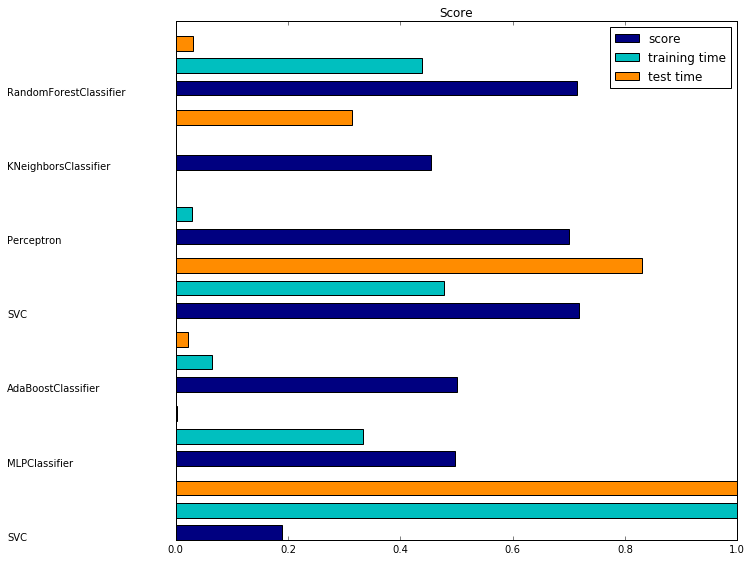

In [21]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (SVC(kernel="linear", C=0.025), "SVC Linear"),
        (MLPClassifier(alpha=1),"MLP "),
        (AdaBoostClassifier(),"Adaboost "),
        (SVC(gamma=2, C=1),"SVC non Linear"),
        (Perceptron(n_iter=50), "Perceptron"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()